# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

import scipy.stats as stats

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import Dataframes

In [2]:
# Taken from web scraper (scraped multiple times to obtain more data as Reddit only saves a certain amount)
df1 = pd.read_csv('raw_data/post_data_10_4.csv')
df2 = pd.read_csv('raw_data/post_data_10_6.csv')
df3 = pd.read_csv('raw_data/post_data_10_7.csv')
df4 = pd.read_csv('raw_data/post_data_10_8.csv')
df5 = pd.read_csv('raw_data/post_data_10_9.csv')
df6 = pd.read_csv('raw_data/post_data_10_10.csv')

In [3]:
df = pd.concat([df6,df5,df4,df3,df2,df1]).reset_index()

In [4]:
# remove all the duplicate posts that were overlapping due to the manner in which the data was obtained
# Deletes the older posts so the post with more upvotes, comments, etc is saved
df = df.drop_duplicates(subset=['title'])

In [5]:
df = df[["upvotes", "title", "site", "time_posted", "post_age", "comment_no"]]

In [6]:
df.head()

,upvotes,title,site,time_posted,post_age,comment_no
0,0,The Far Right Isn’t the Only Rising Force in G...,theatlantic.com,2018-10-10 18:49:33,0 days 00:02:20.444008000,0
1,0,Mexico: Mayor accused of spending taxpayers' m...,mexiconewsdaily.com,2018-10-10 18:48:57,0 days 00:02:56.444011000,0
2,0,Chinese spy charged with stealing U.S. militar...,washingtonpost.com,2018-10-10 18:48:22,0 days 00:03:31.444012000,1
3,0,Mexico: 5 Mexico City police arrested for stea...,mexiconewsdaily.com,2018-10-10 18:43:55,0 days 00:07:58.444012000,0
4,0,Mexico: World Justice Project study finds weak...,mexiconewsdaily.com,2018-10-10 18:40:32,0 days 00:11:21.444013000,1


# Convert to Datetime

In [7]:
df['time_posted'] = pd.to_datetime(df['time_posted'])

In [8]:
def to_timedelta(item):
    return pd.Timedelta(item[:-10])

df['post_age'] = df['post_age'].apply(to_timedelta)

In [9]:
df = df[["upvotes", "title", "site", "time_posted", "post_age", "comment_no"]]

In [10]:
# create a new variable; the hour of day that the post was made
def to_hour(item):
    return item.hour

df['hour_posted'] = df['time_posted'].apply(to_hour)

In [11]:
df = df[["upvotes", "title", "site", "time_posted",'hour_posted', "post_age", "comment_no"]]

# Delete Posts Under Three Hours

In [12]:
three_hours = pd.Timedelta('3 hours')
df = df[df.post_age >= three_hours].reset_index()
df = df[["upvotes", "title", "site", "time_posted",'hour_posted', "post_age", "comment_no"]]

# Add a Post Length Variable

In [13]:
def length(item):
    sentence = item.split(" ")
    return len(sentence)

df['title_length'] = df['title'].apply(length)
df = df[["upvotes", "title",'title_length', "site", "time_posted",'hour_posted', "post_age", "comment_no"]]

In [14]:
df.head()

,upvotes,title,title_length,site,time_posted,hour_posted,post_age,comment_no
0,7,Soaring Rice Prices Are Dulling Duterte’s Lust...,9,nytimes.com,2018-10-10 15:49:49,15,03:02:05,2
1,11,Man who sold stolen identities sentenced to pr...,11,reuters.com,2018-10-10 15:38:01,15,03:13:53,2
2,42,China okays massive re-education camps for Mus...,13,businessinsider.com,2018-10-10 15:35:19,15,03:16:35,8
3,17,Indonesian tourists vandalize Olmec monumental...,8,theyucatantimes.com,2018-10-10 15:28:44,15,03:23:10,5
4,5,UNESCO: Rachel's Tomb and Cave of Patriarchs p...,11,jpost.com,2018-10-10 15:27:11,15,03:24:43,7


# Analyze Upvote Variable

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


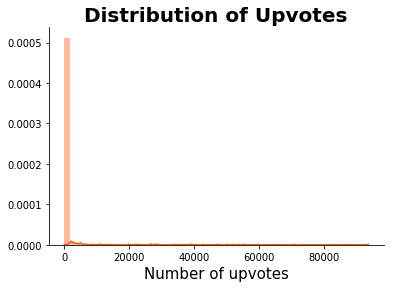

In [15]:
# Plot the distribution 
upvotes = df['upvotes'].values
sns.distplot(upvotes, color= '#FF5700');
plt.title('Distribution of Upvotes', fontsize = 20, weight = 'bold')
plt.xlabel('Number of upvotes', fontsize = 15)
sns.despine();

In [16]:
df['upvotes'].describe()

count     2254.000000
mean       887.414818
std       6084.253352
min          0.000000
25%          5.000000
50%         12.000000
75%         39.000000
max      93700.000000
Name: upvotes, dtype: float64

In [17]:
def to_log(item):
    return np.log1p(item)

df["upvotes_logged"] = df["upvotes"].apply(to_log)

In [18]:
double_log = df["upvotes_logged"].apply(to_log)

In [19]:
df = df[["upvotes","upvotes_logged", "title",'title_length', "site", "time_posted",'hour_posted', "post_age", "comment_no"]]

In [20]:
df.head()

,upvotes,upvotes_logged,title,title_length,site,time_posted,hour_posted,post_age,comment_no
0,7,2.079442,Soaring Rice Prices Are Dulling Duterte’s Lust...,9,nytimes.com,2018-10-10 15:49:49,15,03:02:05,2
1,11,2.484907,Man who sold stolen identities sentenced to pr...,11,reuters.com,2018-10-10 15:38:01,15,03:13:53,2
2,42,3.761200,China okays massive re-education camps for Mus...,13,businessinsider.com,2018-10-10 15:35:19,15,03:16:35,8
3,17,2.890372,Indonesian tourists vandalize Olmec monumental...,8,theyucatantimes.com,2018-10-10 15:28:44,15,03:23:10,5
4,5,1.791759,UNESCO: Rachel's Tomb and Cave of Patriarchs p...,11,jpost.com,2018-10-10 15:27:11,15,03:24:43,7


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


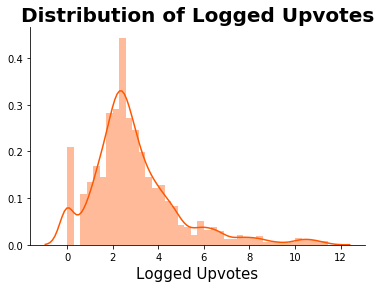

In [21]:
# Plot the distribution of Logged Upvotes
upvotes1 = df['upvotes_logged'].values
sns.distplot(upvotes1, color= '#FF5700');
plt.title('Distribution of Logged Upvotes', fontsize = 20, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 15)
sns.despine();

In [22]:
df.describe()

,upvotes,upvotes_logged,title_length,hour_posted,post_age,comment_no
count,2254.000000,2254.000000,2254.000000,2254.000000,2254,2254.000000
mean,887.414818,2.974696,14.936114,11.685892,1 days 22:16:57.894853,70.420586
std,6084.253352,1.973716,10.077216,5.935801,0 days 21:05:25.488515,394.964544
min,0.000000,0.000000,4.000000,0.000000,0 days 03:02:05,0.000000
25%,5.000000,1.791759,9.000000,7.000000,1 days 07:37:58.750000,1.000000
50%,12.000000,2.564949,11.000000,12.000000,2 days 01:54:15,4.000000
75%,39.000000,3.688879,15.000000,16.000000,2 days 13:51:39,13.000000
max,93700.000000,11.447864,53.000000,23.000000,3 days 12:32:14,7730.000000


# Create Dummy Variables 

In [23]:
# Website dummy variables

In [24]:
sites_dummy = pd.get_dummies(df['site'])
# drop infrequently used sites to prevent overfitting
sites_dummy.drop([col for col, val in sites_dummy.sum().iteritems() if val < 15], axis=1, inplace=True)

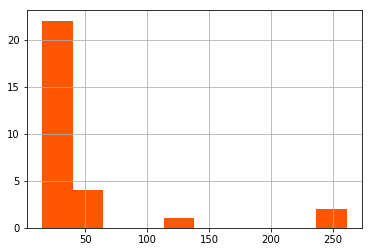

In [25]:
sites_dummy.sum().hist(color= '#FF5700')

In [26]:
sites_dummy.sum().sort_values(ascending=False)

reuters.com            261
theguardian.com        246
bbc.com                130
bbc.co.uk               62
independent.co.uk       49
aljazeera.com           46
dw.com                  45
edition.cnn.com         37
cbc.ca                  34
apnews.com              32
nytimes.com             31
cnbc.com                31
washingtonpost.com      26
timesofisrael.com       24
news.sky.com            24
abc.net.au              24
bloomberg.com           23
thedailybeast.com       23
cnn.com                 21
japantimes.co.jp        20
channelnewsasia.com     19
businessinsider.com     19
abcnews.go.com          19
scmp.com                17
france24.com            16
themoscowtimes.com      16
en.crimerussia.com      15
euractiv.com            15
dailymail.co.uk         15
dtype: int64

In [27]:
# Time posted dummy variables

In [28]:
hour_dummy = pd.get_dummies(df['hour_posted'])

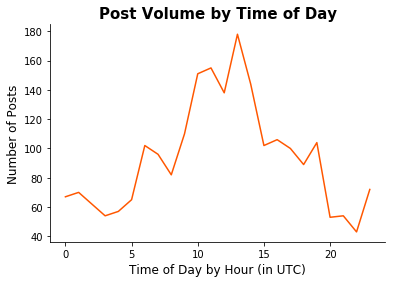

In [29]:
hour_dummy.sum().plot(color= '#FF5700')
plt.title('Post Volume by Time of Day', fontsize = 15, weight = 'bold')
plt.ylabel('Number of Posts', fontsize = 12)
plt.xlabel('Time of Day by Hour (in UTC)', fontsize = 12)
sns.despine();

In [30]:
# Post age dummy variables

In [31]:
bins = []
labels = []
for item in range(0,90,5):
    string = str(item) + 'hours'
    bins.append(pd.Timedelta(string))
    labels.append(item)
    
labels = labels[1:]

In [32]:
df['post_age_hours'] = pd.cut(df['post_age'], bins=bins, labels=labels)

In [33]:
age_dummy = pd.get_dummies(df['post_age_hours'])
df_age = pd.concat([df, age_dummy], axis = 1)

# Convert Text Data to Sparse Matrix Using Count Vectorizer

In [34]:
# Convert title to only letters
df['title'] = df['title'].str.replace('[^a-z, A-Z]', '')

In [35]:
count_vect = CountVectorizer(stop_words = 'english', ngram_range=(1, 2))
counts = count_vect.fit_transform(df['title'])

In [36]:
counts.shape

(2254, 24153)

In [37]:
# Create a sparse matrix with the counts
def wm2df(wm, feat_names):
    doc_names = ['{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)
tokens = count_vect.get_feature_names()
count_words_df = wm2df(counts, tokens)

In [38]:
common_words = count_words_df.sum().sort_values()

In [39]:
# See common words
common_words.tail(10)

trump       70
india       72
said        77
russia      79
russian     86
uk          96
saudi      107
new        128
china      141
says       176
dtype: int64

In [40]:
# Sparse matrix without seldom used words
word_series = common_words.loc[common_words >= 10]
word_list = list(word_series.index.values)
select_count = count_words_df[word_list]

In [41]:
# Create a variable that is the number of top words used divided by length of the post
select_count['sum'] = select_count.sum(axis=1)
count_whole_df = pd.concat([df.reset_index(drop=True), select_count.reset_index(drop=True)], axis= 1)
count_whole_df["average"] = (count_whole_df["sum"]/count_whole_df["title_length"])
count_avg = count_whole_df["average"]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Convert Text Data to Sparse Matrix Using Tfidf Vectorizer

In [42]:
count_vect = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 2))
counts = count_vect.fit_transform(df['title'])

In [43]:
tokens = count_vect.get_feature_names()
tfidf_words_df = wm2df(counts, tokens)

In [44]:
common_words = tfidf_words_df.sum().sort_values()

In [45]:
common_words.tail(10)

north      10.447365
trump      10.719499
india      12.184080
russian    12.591774
russia     12.684590
uk         12.688546
new        14.570317
saudi      15.682268
china      19.247975
says       21.184221
dtype: float64

In [46]:
# Sparse matrix without seldom used words
word_series = common_words.loc[common_words >= 1.4]
word_list = list(word_series.index.values)
select_tfidf = tfidf_words_df[word_list]

In [47]:
# Create a variable that is the number of top words used divided by length of the post
tfidf_words_df['sum'] = tfidf_words_df.sum(axis=1)
tfidf_avg = tfidf_words_df["sum"]

# Variables

In [48]:
upvote_df = df['upvotes']
log_upvote_df = df['upvotes_logged']
len_df = df['title_length']
time_df = df['time_posted']
age_df = df['post_age']
comment_df = df['comment_no']

In [49]:
# df

# upvote_df
# log_upvote_df
# double_log

# count_words_df
# select_count
# count_avg

# tfidf_words_df
# select_tfidf
# tfidf_avg

# len_df

# sites_dummy 

# time_df
# hour_dummy

# age_df
# age_dummy

# comment_df

# Make Dataframes

In [50]:
def to_secs(item):
    return item.total_seconds()

In [51]:
# Test relationship between time of day and upvotes
df1 = pd.concat([log_upvote_df.reset_index(drop=True),
                 hour_dummy.reset_index(drop=True),
                ], axis= 1)

In [52]:
# Test how good tfidf is on its own
df2 = pd.concat([log_upvote_df.reset_index(drop=True),
                 tfidf_words_df.reset_index(drop=True),
                ], axis= 1)

In [53]:
# Try without upvote outliers
df3 = df2[df2.upvotes_logged <= 6.0].reset_index()

In [54]:
# Try with more features
df4 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_tfidf.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                 hour_dummy.reset_index(drop=True),
                 age_dummy.reset_index(drop=True)
                ], axis= 1)

In [55]:
# Again without upvote outliers
df5 = df4[df4.upvotes_logged <= 6.0].reset_index()

In [56]:
# Same but with continuous age instead of dummies
df6 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_tfidf.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                 hour_dummy.reset_index(drop=True),
                 age_df.reset_index(drop=True)
                ], axis= 1)
df6['post_age'] = df6['post_age'].apply(to_secs)

In [57]:
# Same but with sites
df7 = pd.concat([log_upvote_df.reset_index(drop=True),
                  select_tfidf.reset_index(drop=True),
                  len_df.reset_index(drop=True),
                  sites_dummy.reset_index(drop=True),
                  hour_dummy.reset_index(drop=True),
                  age_df.reset_index(drop=True)
                ], axis= 1)
df7['post_age'] = df7['post_age'].apply(to_secs)

In [58]:
# Same with double log on upvotes
df8 = pd.concat([double_log.reset_index(drop=True),
                  select_tfidf.reset_index(drop=True),
                  len_df.reset_index(drop=True),
                  sites_dummy.reset_index(drop=True),
                  hour_dummy.reset_index(drop=True),
                  age_df.reset_index(drop=True)
                ], axis= 1)
df8['post_age'] = df8['post_age'].apply(to_secs)

In [59]:
# Same but with single log
df9 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_tfidf.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                  sites_dummy.reset_index(drop=True),
                 age_df.reset_index(drop=True)
                ], axis= 1)
df9['post_age'] = df9['post_age'].apply(to_secs)

In [60]:
# Same but without hour dummies 
df10 = pd.concat([double_log.reset_index(drop=True),
                 select_tfidf.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                  sites_dummy.reset_index(drop=True),
                 age_df.reset_index(drop=True)
                ], axis= 1)
df10['post_age'] = df10['post_age'].apply(to_secs)

In [61]:
# Best set of features
df11 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_count.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                 age_df.reset_index(drop=True),
                ], axis= 1)
df11['post_age'] = df11['post_age'].apply(to_secs)

In [62]:
# Visualization Dataframe
df12 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_count.reset_index(drop=True),
                ], axis= 1)

# Regressions

In [63]:
lr = LinearRegression()

In [64]:
# df1

In [65]:
X = df1.loc[:, df1.columns != 'upvotes_logged']
y = df1['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [66]:
cross_val_score(lr, X_train, y_train,
                cv=10,
                scoring='r2') 

array([-0.03345006, -0.02746699, -0.00393135, -0.00392097, -0.02261835,
       -0.04981983,  0.00060541, -0.00448453, -0.00672628, -0.02259913])

In [67]:
rcv = RidgeCV(cv=5)
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [68]:
rcv.score(X_train, y_train)

0.017064593110406534

In [69]:
rcv.score(X_test, y_test)

-0.0013829020611808573

In [70]:
# df2

In [71]:
X = df2.loc[:, df2.columns != 'upvotes_logged']
y = df2['upvotes_logged']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [73]:
rcv = RidgeCV(alphas=(0.1, 1, 5, 10, 20.0,100), cv=5)

In [74]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1, 5, 10, 20.0, 100), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [75]:
rcv.alpha_

1

In [76]:
rcv.score(X_train, y_train)

0.7423977216049572

In [77]:
rcv.score(X_test, y_test)

0.10610178002533499

In [78]:
results = rcv.predict(X_train)

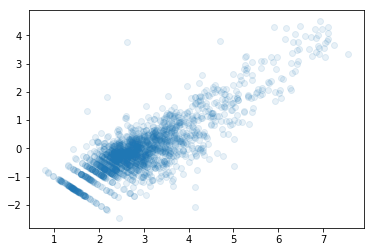

In [79]:
plt.scatter(results,y_train-results,alpha=.1)
# plt.plot(np.linspace(0,10,10),np.linspace(0,10,10))

In [80]:
rcv.score(X_test, y_test)

0.10610178002533499

In [81]:
# try Lasso

In [82]:
lcv = LassoCV(cv=5)
lcv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [83]:
lcv.score(X_train, y_train)

0.03997930305238129

In [84]:
lcv.score(X_test, y_test)

0.07547475580898266

In [85]:
# df3
X = df3.loc[:, df3.columns != 'upvotes_logged']
y = df3['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [86]:
rcv = RidgeCV(alphas=(0.1,1,2,3,50.0), cv=5)

In [87]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1, 2, 3, 50.0), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [88]:
rcv.alpha_

3

In [89]:
rcv.score(X_train, y_train)

0.45651101527879134

In [90]:
rcv.score(X_test, y_test)

0.0396769983241434

In [91]:
# df4

In [92]:
X = df4.loc[:, df4.columns != 'upvotes_logged']
y = df4['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [93]:
rcv = RidgeCV(alphas=(0.1, 1,10, 20.0, 100), cv=5)

In [94]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1, 10, 20.0, 100), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [95]:
rcv.alpha_

100

In [96]:
rcv.score(X_train, y_train)

0.0737454513643685

In [97]:
rcv.score(X_test, y_test)

0.09455049031099128

In [98]:
# df5

In [99]:
X = df5.loc[:, df5.columns != 'upvotes_logged']
y = df5['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [100]:
rcv = RidgeCV(alphas=(186.0, 187.0, 189.0, 190.0), cv=5)

In [101]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(186.0, 187.0, 189.0, 190.0), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [102]:
rcv.alpha_

186.0

In [103]:
rcv.score(X_train, y_train)

0.06635455551976177

In [104]:
rcv.score(X_test, y_test)

0.025494504139539242

In [105]:
# df6 (BEST)

In [106]:
X = df6.loc[:, df6.columns != 'upvotes_logged']
y = df6['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [107]:
rcv = RidgeCV(alphas=(0.1,1,2,3, 4,5,6,7, 10,1000), cv=5)

In [108]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1, 2, 3, 4, 5, 6, 7, 10, 1000), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [109]:
rcv.alpha_

2

In [110]:
rcv.score(X_train, y_train)

0.20237334167217202

In [111]:
rcv.score(X_test, y_test)

0.11224435472709404

In [112]:
# df7

In [113]:
X = df7.loc[:, df7.columns != 'upvotes_logged']
y = df7['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [114]:
rcv = RidgeCV(alphas=(30.75,31.0,31.25), cv=5)

In [115]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(30.75, 31.0, 31.25), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [116]:
rcv.alpha_

31.25

In [117]:
rcv.score(X_train, y_train)

0.10690882578255345

In [118]:
rcv.score(X_test, y_test)

0.10272982157820099

In [119]:
# df8

In [120]:
X = df7.loc[:, df7.columns != 'upvotes_logged']
y = df7['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [121]:
rcv = RidgeCV(alphas=(30.75,31.0,31.25), cv=5)

In [122]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(30.75, 31.0, 31.25), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [123]:
rcv.alpha_

31.25

In [124]:
rcv.score(X_train, y_train)

0.10690882578255345

In [125]:
rcv.score(X_test, y_test)

0.10272982157820099

In [126]:
# df9

In [127]:
X = df9.loc[:, df9.columns != 'upvotes_logged']
y = df9['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [128]:
rcv = RidgeCV(alphas=(9.5,10,10.5), cv=5)

In [129]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(9.5, 10, 10.5), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [130]:
rcv.alpha_

9.5

In [131]:
rcv.score(X_train, y_train)

0.12926006409606783

In [132]:
rcv.score(X_test, y_test)

0.10986896685722845

In [133]:
# df10

In [134]:
X = df10.loc[:, df10.columns != 'upvotes_logged']
y = df10['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [135]:
rcv = RidgeCV(alphas=(1,1.25,1.5,1.75,2.1,2.25), cv=5)

In [136]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(1, 1.25, 1.5, 1.75, 2.1, 2.25), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [137]:
rcv.alpha_

1.75

In [138]:
rcv.score(X_train, y_train)

0.23256932630057736

In [139]:
rcv.score(X_test, y_test)

0.10902164902943856

In [140]:
# df11

In [141]:
X = df11.loc[:, df11.columns != 'upvotes_logged']
y = df11['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
rcv = RidgeCV(alphas=(1,5,33,66,80,100), cv=5)
fit = rcv.fit(X_train, y_train)
rcv.alpha_

80

In [142]:
coefs = []
for item1, item2 in zip(df11.columns.values,rcv.coef_):
    tup = (item1, item2)
    coefs.append(tup)

sorted(coefs, key=lambda x: x[1])

[('missing', -0.2356598259887111),
 ('military', -0.22226126342546676),
 ('khashoggi', -0.2142663523400846),
 ('jamal', -0.21115560226158106),
 ('visit', -0.2093393739690576),
 ('trade deal', -0.18843357341602493),
 ('iran', -0.18605576182338376),
 ('government', -0.18363788060194022),
 ('north', -0.17420257332837388),
 ('saudi', -0.17301305361055627),
 ('health', -0.16534662295049113),
 ('prison', -0.1624382408427186),
 ('officers', -0.1615202666842002),
 ('australian', -0.16149556038001134),
 ('dies', -0.1550624459297385),
 ('climate change', -0.15080628643413035),
 ('india', -0.14176418657475567),
 ('change', -0.13821896472416434),
 ('prime minister', -0.13743027298693955),
 ('sydney opera', -0.13622831753196424),
 ('public', -0.13462965253760276),
 ('ambassador', -0.12794997587478327),
 ('british', -0.12715319863508254),
 ('prize', -0.12651118905184566),
 ('years', -0.12401447090042242),
 ('west', -0.12388477232419813),
 ('worlds', -0.1220100855719762),
 ('reportedly', -0.121659655

In [143]:
rcv.score(X_train, y_train)

0.13856220288101273

In [144]:
rcv.score(X_test, y_test)

0.1213499723599446

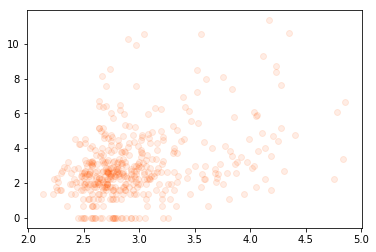

In [145]:
pred = rcv.predict(X_test)
plt.scatter(pred,y_test,alpha=.1, color = '#FF5700')

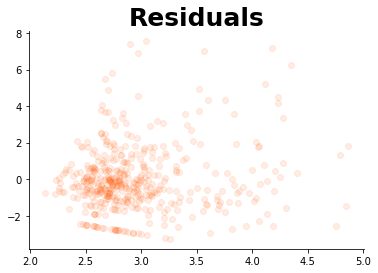

In [146]:
plt.scatter(pred,y_test-pred,alpha=.1, color = '#FF5700')
plt.title('Residuals', fontsize = 25, weight = 'bold')
sns.despine();

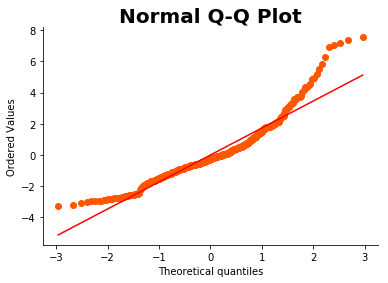

In [147]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(y_test-pred, dist="norm", plot=plt)
ax.get_lines()[0].set_color('#FF5700')
plt.title('Normal Q-Q Plot', fontsize = 20, weight = 'bold')
sns.despine();

In [148]:
np.sqrt(np.mean((pred - y_test)**2))

1.7933432143799197

# Top Word Distributions

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


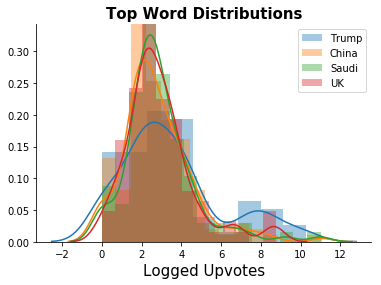

In [149]:
df12 = df12[['upvotes_logged','trump','china','saudi','uk']]
df121 = df12[df12.trump > 0].reset_index(drop=True)
df122 = df12[df12.china > 0].reset_index(drop=True)
df123 = df12[df12.saudi > 0].reset_index(drop=True)
df124 = df12[df12.uk > 0].reset_index(drop=True)

sns.distplot(df121['upvotes_logged'], label = 'Trump')
sns.distplot(df122['upvotes_logged'], label = 'China')
sns.distplot(df123['upvotes_logged'], label = 'Saudi')
sns.distplot(df124['upvotes_logged'], label = 'UK')

plt.title('Top Word Distributions', fontsize = 15, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 15)

plt.legend()
sns.despine();